# Clustering Documents with OpenAI embeddings, HDBSCAN and UMAP Tutorial
Thanks for the contribution from DYLAN CASTILLO, my code is based on the tutorial given by him, and add more details.

Clustering process should be processed in 3 steps:
1. Generate numerical vector representations of documents/texts using OpenAI's embedding capabilities.
2. Apply a clustering algorithm on the vectors to group the documents.
3. Generate a title for each cluster summarizing the articles contained in it.

## Configuration and Data Preparation

In [1]:
## Import the required libraries
import os

import hdbscan # clustering algorithm
import numpy as np
import pandas as pd
import plotly.express as px
import requests
from dotenv import load_dotenv
from openai import OpenAI
from umap import UMAP # for dimensionality reduction and visualizing clusters

load_dotenv("./configuration.env")

/Users/zhant0g/Desktop/clustering/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [67]:
## Load data

df = pd.read_csv("./news_data_dedup.csv")
docs = [
    f"{title}\n{description}"
    for title, description in zip(df.title, df.description)
]
print(f"Loaded {len(docs)} documents")
print(f"Example document: {docs[0]}")

Loaded 870 documents
Example document: Harvey Weinstein's 2020 rape conviction overturned
Victims group describes the New York appeal court's decision to retry Hollywood mogul as "profoundly unjust".


In [ ]:
## Initialize OpenAI API client and generate embeddings
client = OpenAI()
response = client.embeddings.create(input=docs, model="text-embedding-3-small")
embeddings = [np.array(x.embedding) for x in response.data] 

In [11]:
print(type(embeddings))

<class 'list'>


Parameterrs in HDBSCAN:
1. min_samples: it defines the minimum number of points in the neighborhood of a point for it to be considered as a core point, the neighborhood is defined by the distance metric. It impacrs the density estimation of the dataset, a point is considered as a core point if it has at least 'min_samples' points, including itself, within its neighborhood. Lower values will make it easier for points to be considered as core points, leading to more clusters and potentially more noise points being considered. Higher values, in contrast, will potentially result in a few clusters and more points being classified as noise.
2. min_cluster_size: it sets the minimum sie of clusters, which defines the smallest number of points that a cluster can contain. Clusters smaller tha min_cluster_size will be considered as noise. Lower values allow smaller clusters to be formed, which migh include small meaningful clusters or noise clusters. While higher values ensure that only larger, more significant clusters are retained, but might lead to samll meaningful clusters being discarded.

## Evaluate the Impact of Parameters on Clustering Correctness

1. Silhouette Score: it measures how similar a point is to its own cluster compared to other clusters. A higher silhouette score indicates a betteer defined clusters.
2. Davies-Bouldin Index: it measures the average similarity ratio of each cluster with the cluster most similar to it. Loweer values indicates better clustering.
3. Dunn Index: it measures the ratio of minimum inter-cluster distance to the maximum intra-cluster distance. Higher values indicate the clusters are well-separated and compact. While lower score means the clusters are either not well separated, or very spread out. 
   1. Minimum inter-cluster distance: the closest distance between points in different clusters.
   2. Maximum intra-cluster distance: the largest distance between points within the same cluster.

In [18]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_cluster_quality(data, min_samples, min_cluster_size):
    cluster = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    labels = cluster.fit_predict(data)

    ## Ignore the noise points for evaluation
    mask = labels != -1
    data = np.array(data)
    clean_data = data[mask]
    clean_labels = labels[mask]

    if len(np.unique(clean_labels)) > 1:
        silhouette_score_avg = silhouette_score(clean_data, clean_labels)
        davies_bouldin = davies_bouldin_score(clean_data, clean_labels)
    else:
        silhouette_score_avg = -1
        davies_bouldin = np.inf

    return silhouette_score_avg, davies_bouldin, cluster

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

## Test Parameters 
min_samples_value = [3, 5, 10, 20]
min_cluster_size_value = [3, 5, 10, 20]

results = []

for min_samples in min_samples_value:
    for min_cluster_size in min_cluster_size_value:
        silhouette_score_avg, davies_bouldin, cluster = evaluate_cluster_quality(embeddings, min_samples, min_cluster_size)
        print("="*10, f"min_samples: {min_samples}, min_cluster_size: {min_cluster_size}", "="*10)
        print(f"Silhouette Score: {silhouette_score_avg}")
        print(f"Davies Bouldin Score: {davies_bouldin}")
        print(f"Number of clusters: {len(np.unique(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)}")
        print(f"Number of nosie points: {(cluster.labels_ == -1).sum()}") 
        results.append({
            "min_samples": min_samples,
            "min_cluster_size": min_cluster_size,
            "silhouette_score": silhouette_score_avg,
            "davies_bouldin": davies_bouldin,
            "num_clusters": len(np.unique(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0),
            "num_noise_points": (cluster.labels_ == -1).sum()
        })

========== min_samples: 3, min_cluster_size: 3 ==========
Silhouette Score: 0.20702545297476813
Davies Bouldin Score: 1.629948203744836
Number of clusters: 58
Number of nosie points: 283
========== min_samples: 3, min_cluster_size: 5 ==========
Silhouette Score: 0.19726359526787593
Davies Bouldin Score: 1.707405676173979
Number of clusters: 45
Number of nosie points: 299
========== min_samples: 3, min_cluster_size: 10 ==========
Silhouette Score: 0.14944167752636098
Davies Bouldin Score: 2.1104890692428873
Number of clusters: 16
Number of nosie points: 390
========== min_samples: 3, min_cluster_size: 20 ==========
Silhouette Score: 0.14128821374879916
Davies Bouldin Score: 2.2426675272166396
Number of clusters: 9
Number of nosie points: 455
========== min_samples: 5, min_cluster_size: 3 ==========
Silhouette Score: 0.21601401001043555
Davies Bouldin Score: 1.5945659299480504
Number of clusters: 37
Number of nosie points: 432
========== min_samples: 5, min_cluster_size: 5 ==========
Sil

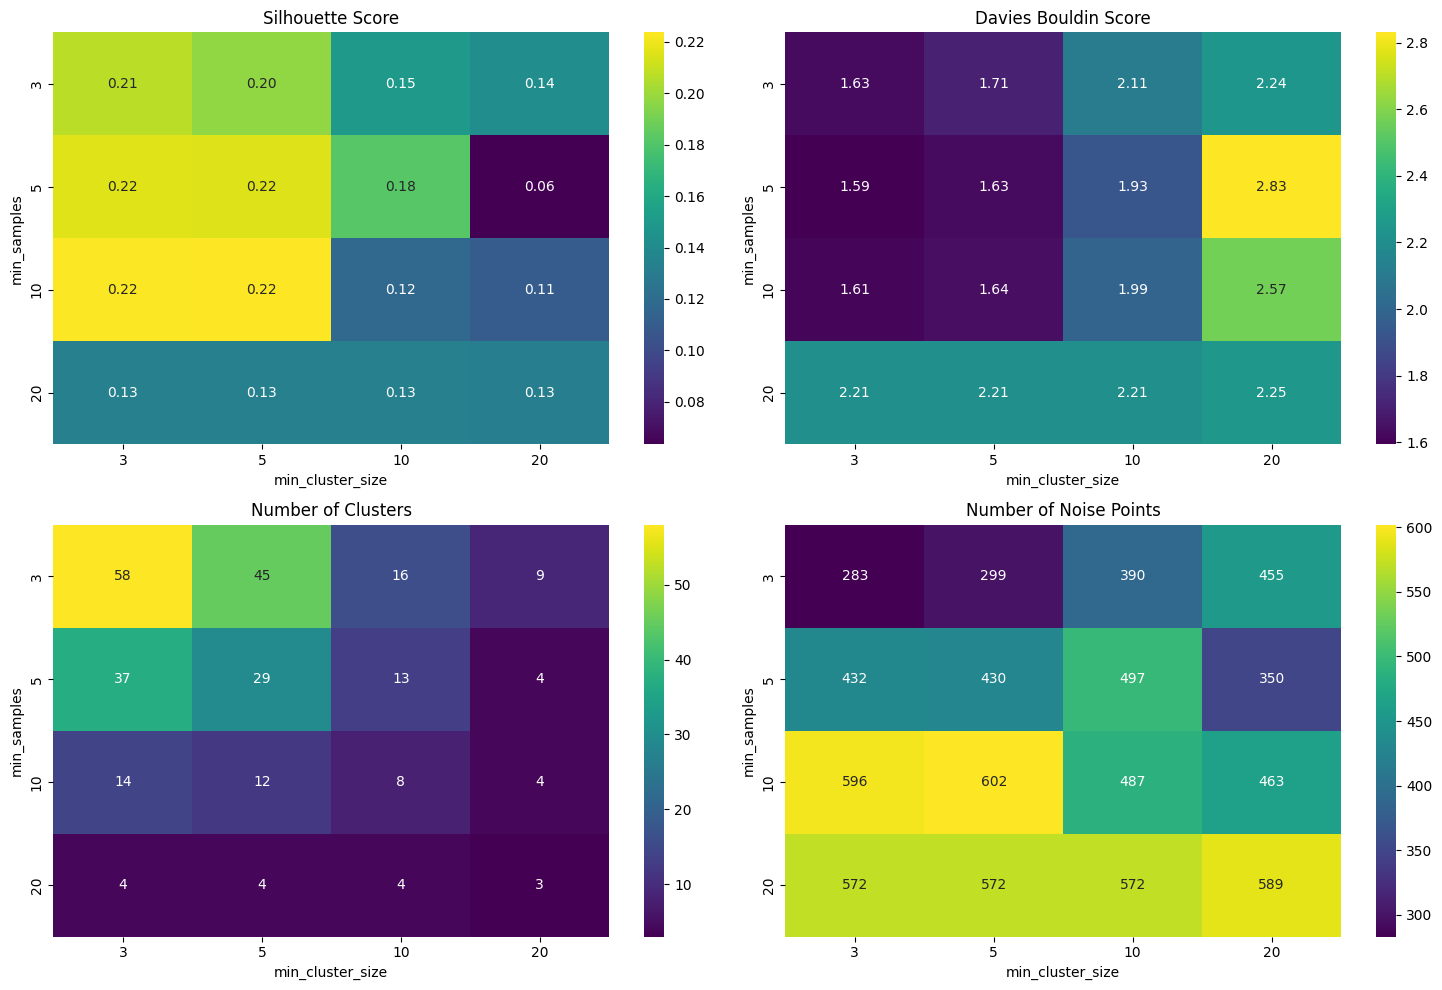

In [28]:
results_df = pd.DataFrame(results, columns=["min_samples", "min_cluster_size", "silhouette_score", "davies_bouldin", "num_clusters", "num_noise_points"])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

## Silhouette Score Heatmap
pivot_silhouette = results_df.pivot(index="min_samples", columns="min_cluster_size", values="silhouette_score")
sns.heatmap(pivot_silhouette, annot=True, fmt=".2f", cmap="viridis", ax=axes[0, 0])
axes[0, 0].set_title("Silhouette Score")

## Davies Bouldin Score Heatmap
pivot_daives = results_df.pivot(index="min_samples", columns="min_cluster_size", values="davies_bouldin")
sns.heatmap(pivot_daives, annot=True, fmt=".2f", cmap="viridis", ax=axes[0, 1])
axes[0, 1].set_title("Davies Bouldin Score")

## Number of Clusters Heatmap
pivot_num_clusters = results_df.pivot(index="min_samples", columns="min_cluster_size", values="num_clusters")
sns.heatmap(pivot_num_clusters, annot=True, fmt=".0f", cmap="viridis", ax=axes[1, 0])
axes[1, 0].set_title("Number of Clusters")

# Number of Noise Points Heatmap
pivot_num_noise_points = results_df.pivot(index="min_samples", columns="min_cluster_size", values="num_noise_points")
sns.heatmap(pivot_num_noise_points, annot=True, fmt=".0f", cmap="viridis", ax=axes[1, 1])
axes[1, 1].set_title("Number of Noise Points")

plt.tight_layout()
plt.show()

In [30]:
## Visualization using UMAP

best_params_silhouette = results_df.sort_values(by="silhouette_score", ascending=False).iloc[0]
print(f"Best Parameters based on Silhouette Score: {best_params_silhouette}")

best_params_davies = results_df.sort_values(by="davies_bouldin", ascending=True).iloc[0]
print(f"Best Parameters based on Davies Bouldin Score: {best_params_davies}")

if best_params_silhouette.equals(best_params_davies):
    best_params = best_params_silhouette
    print("Both metrics agree on the best parameters")
else:
    best_params = best_params_silhouette
    print("Metrics do not agree on the best parameters, Using Silhouette Score as the best parameters")

best_min_samples = int(best_params.min_samples)
best_min_cluster_size = int(best_params.min_cluster_size)
best_clusterer = hdbscan.HDBSCAN(min_samples=best_min_samples, min_cluster_size=best_min_cluster_size)
best_labels = best_clusterer.fit_predict(embeddings)

umap = UMAP(n_components=2, random_state=42, n_neighbors=80, min_dist=0.1)
df_umap = (
    pd.DataFrame(umap.fit_transform(np.array(embeddings)), columns=["x", "y"])
    .assign(cluster=lambda df: best_labels.astype(str))
    .query('cluster != "-1"')
    .sort_values(by="cluster")
)

fig = px.scatter(df_umap, x="x", y="y", color="cluster")
fig.show()

Best Parameters based on Silhouette Score: min_samples          10.000000
min_cluster_size      5.000000
silhouette_score      0.223640
davies_bouldin        1.641621
num_clusters         12.000000
num_noise_points    602.000000
Name: 9, dtype: float64
Best Parameters based on Davies Bouldin Score: min_samples           5.000000
min_cluster_size      3.000000
silhouette_score      0.216014
davies_bouldin        1.594566
num_clusters         37.000000
num_noise_points    432.000000
Name: 4, dtype: float64
Metrics do not agree on the best parameters, Using Silhouette Score as the best parameters


/Users/zhant0g/Desktop/clustering/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Create a Topic per Cluster

In [72]:
df["cluster"] = best_labels
df["cluster_name"] = "Uncategorized"

def generate_topic_titles():
    system_msg = "You are an expert journalist. You're helping me write short but compelling topic titles for groups of news articles."
    user_template = "Using the following articles, writea 4 to 5 word title that summarizes them. \n\nARTICLES:\n\n{}\n\nTOPIC TITLE:"

    for c in df.cluster.unique():
        sample_articles = df.query(f"cluster == {c}").to_dict(orient="records")
        articles_str = "\n\n".join(
            [
                f"[{i}] {article['title']}\n{article['description'][:30]}{'...' if len(article['description']) > 30 else ''}"
                for i, article in enumerate(
                    sample_articles, start=1
                )
            ]
        )
        messages = [
            {"role": "system", "content": system_msg},
            {"role": "user", "content": user_template.format(articles_str)}
        ]
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            temperature=0.7,
            seed=42
        )

        topic_title = response.choices[0].message.content
        df.loc[df.cluster == c, "cluster_name"] = topic_title
        print(f"Cluster {c} - {topic_title}")

In [73]:
generate_topic_titles()

Cluster 5 - "Harvey Weinstein's Conviction Overturned: Backlash and Reactions"
Cluster 10 - "Campus Clashes Over Gaza Protests"
Cluster -1 - Global Events Impacting Society
Cluster 0 - "Political Turmoil Surrounding Spanish PM"
Cluster 6 - "Supreme Court Debates Trump's Immunity"
Cluster 9 - "US Military Aid Boosts Ukraine"
Cluster 3 - "Big Tech AI Investment Impact"
Cluster 8 - "US-China Relations: Blinken's Diplomatic Efforts"
Cluster 11 - "Intense negotiation efforts in Gaza"
Cluster 7 - "TikTok's Global Battle Unfolds"
Cluster 4 - "Corporate Giants Clash: BHP vs Anglo American"
Cluster 1 - "Soccer Stories: League Updates & Dramatic Matches"
Cluster 2 - "Economic Data Sparks Investor Concern"


In [76]:
c = 1 
with pd.option_context("display.max_colwidth", None):
    print(df.query(f"cluster == {c}").cluster_name.values[0])
    print(len(df.query(f"cluster == {c}")))
    display(df.query(f"cluster == {c}").drop(columns=["cluster_name", "guid"]))

"Soccer Stories: League Updates & Dramatic Matches"
45


,title,description,venue,url,published_at,updated_at,cluster
168,Brighton v Manchester City: Premier League – live,"Premier League live updates from the 8pm BST kick-offLive scoreboard | Read Football Daily | And email Scott5 min: Joao Pedro steals the ball in midfield and races into the City half. He’s got options on either side but takes the wrong one, passing to Veltman on his right. Veltman runs into trouble immediately and the counter peters out. “Greetings from Virginia,” begins Eagle Brosi. “The quality of the American league is so poor that I’m usually happy to catch any EPL match but I find Pep without Jack Grealish to be so so boring. There’s something so horribly funny about watching Jack, with his tiny shinpads, run into his opponent, fall down and see the ref just get totally conned. I guess spending the preseason drunk isn’t wise? But I miss the only likeable/watchable thing about this City team. Here’s hoping he gets at least a 15-minute cameo.”3 min: Gross makes a nuisance of himself down the inside-left channel. The ball breaks to Welbeck, arriving on the overlap. Welbeck lashes a low first-time effort towards the bottom right, but Ederson fields it at full stretch. A bright start by both teams. Continue reading...",The Guardian,https://www.theguardian.com/football/live/2024/apr/25/brighton-v-manchester-city-premier-league-live,2024-04-25 20:06:00+00,2024-04-26 20:03:02.275976+00,1
172,England’s Marlie Packer: ‘I’d give my son the world – dad did none of that for me’,"Captain reflects on her mum being a ‘rock’ and the Red Roses’ new coach as they chase another Six Nations grand slam‘We’re in France and the crowd is going to be hostile,” Marlie Packer says as she looks ahead to Saturday’s Six Nations grand slam&nbsp;decider in Bordeaux with relish. “But we know that can flip on its head because of the French crowd. If they’re not happy with the way their team are playing, they&nbsp;turn on&nbsp;them and give them a bit of a&nbsp;hard time.”Packer will win her 104th cap and, as captain, she also knows England have not lost a Six Nations match in six years. She played in that last defeat, away to France in Grenoble in March 2018, and so she has an acute awareness of the light and shade in rugby and life. Packer has lost two agonising World Cup finals, to New Zealand, but she helped England win the tournament in 2014. Continue reading...",The Guardian,https://www.theguardian.com/sport/2024/apr/25/marlie-packer-england-women-rugby-union-six-nations-grand-slam,2024-04-25 18:00:16+00,2024-04-26 20:03:02.345321+00,1
180,Have Everton dashed Liverpool’s title dreams? – Football Weekly Extra,"Max Rushden is joined by Barry Glendenning, Jonathan Liew and Robyn Cowen as Liverpool lose the Merseyside derby … and maybe moreRate, review, share on Apple Podcasts, Soundcloud, Audioboom, Mixcloud, Acast and Stitcher, and join the conversation on Facebook, Twitter and email.On the podcast today: Everton sink Liverpool in a Merseyside derby that could be the end of the Reds’ title hopes, and which may well be enough to secure the Toffees’ Premier League status. Continue reading...",The Guardian,https://www.theguardian.com/football/audio/2024/apr/25/have-everton-dashed-liverpool-title-dreams-football-weekly-extra-podcast,2024-04-25 10:48:29+00,2024-04-26 20:03:02.476884+00,1
181,Arsenal thrash Chelsea and a Football League update – Football Weekly,"Max Rushden is joined by Barry Glendenning, Ben Fisher, Sanny Rudravajhala and George Elek as Arsenal beat Chelsea 5-0 and to run through the EFL as those divisions reach a conclusion in the coming weeksRate, review, share on Apple Podcasts, Soundcloud, Audioboom, Mixcloud, Acast and Stitcher, and join the conversation on Facebook, Twitter and email.On the podcast today; Arsenal keep pace at the top of the Premier League – were they brilliant or are Chelsea inexcusably bad? It’s probably a touch of both. Continue reading...",The Guardian,https://www.theguardian.com/football/audio/2024/ap